# Set up

## Python path

In [9]:
from pathlib import Path
import sys

# Add the parent directory to the system path
notebook_dir = Path().absolute()
sys.path.append(str(notebook_dir.parent))

## Packages

In [ ]:
from basis_expansions import (
    CubicSpline,
    NaturalCubicSpline,
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrix, build_design_matrices
import seaborn as sns

import const
import utils

## Constants

## Set defaults

In [11]:
utils.set_default_plot_style()

## Functions

In [12]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


class AbstractSpline(BaseEstimator, TransformerMixin):
    """Base class for all spline basis expansions."""
    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None, knot_strategy='even'):
        self.knots = knots
        self.min, self.max = min, max
        self.knot_strategy = knot_strategy
        if knots is None:
            if n_knots is None:
               n_knots = self._compute_n_knots(n_params)
            self.n_knots = n_knots
        else:
            self.n_knots = len(knots)

    def fit(self, X, *args, **kwargs):
        if self.min is None:
            self.min = X.min()
        if self.max is None:
            self.max = X.max()
        if self.knots is None:
            if self.knot_strategy == 'even':
                self.knots = np.linspace(self.min, self.max, num=(self.n_knots + 2))[1:-1]
            elif self.knot_strategy == 'quantiles':
                quantiles = np.linspace(0.0, 1.0, num=(self.n_knots + 2))[1:-1]
                self.knots = np.quantile(X, quantiles)
        return self

class CubicSpline(AbstractSpline):
    """Apply a piecewise cubic basis expansion to an array.


    The features created with this basis expansion can be used to fit a
    piecewise cubic function.  The fitted curve is continuously differentiable
    to the second order at all of the knots.

    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.

    Parameters
    ----------
    min: float
        Minimum of interval containing the knots.

    max: float
        Maximum of the interval containing the knots.

    n_knots: positive integer
        The number of knots to create.

    knot_strategy: str
        Strategy for determining the knots at fit time. Current options are:
          - 'even': Evenly position the knots within the range (min, max).
          - 'quantiles': Set the knots to even quantiles of the data distribution.

    knots: array or list of floats
        The knots.
    """
    def _compute_n_knots(self, n_params):
        return n_params - 3

    @property
    def n_params(self):
        return self.n_knots + 3

    def transform(self, X, **transform_params):
        if isinstance(X, pd.DataFrame):
            assert X.shape[1] == 1
            X = X.iloc[:, 0]
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        second_name = "{}_spline_quadratic".format(X.name)
        third_name = "{}_spline_cubic".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots)]
        return [first_name, second_name, third_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = np.asarray(X).reshape(-1)
        X_spl = np.zeros((X.shape[0], self.n_knots + 3))
        X_spl[:, 0] = X
        X_spl[:, 1] = X_spl[:, 0] * X_spl[:, 0]
        X_spl[:, 2] = X_spl[:, 1] * X_spl[:, 0]
        for i, knot in enumerate(self.knots, start=3):
            X_spl[:, i] = np.maximum(0, (X - knot)*(X - knot)*(X - knot))
        return X_spl


class NaturalCubicSpline(AbstractSpline):
    """Apply a natural cubic basis expansion to an array.

    The features created with this basis expansion can be used to fit a
    piecewise cubic function under the constraint that the fitted curve is
    linear *outside* the range of the knots..  The fitted curve is continuously
    differentiable to the second order at all of the knots.

    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.

    Parameters
    ----------
    min: float
        Minimum of interval containing the knots.

    max: float
        Maximum of the interval containing the knots.

    n_knots: positive integer
        The number of knots to create.

    knot_strategy: str
        Strategy for determining the knots at fit time. Current options are:
          - 'even': Evenly position the knots within the range (min, max).
          - 'quantiles': Set the knots to even quantiles of the data distribution.

    knots: array or list of floats
        The knots.
    """
    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        if isinstance(X, pd.DataFrame):
            assert X.shape[1] == 1
            X = X.iloc[:, 0]
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                     for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = np.asarray(X).reshape(-1)
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError:
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X

        def d(knot_idx, x):
            ppart = lambda t: np.maximum(0, t)
            cube = lambda t: t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                            - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X))
        return X_spl

# Generate sample data

In [13]:
# !pip install regressio --upgrade
try:
    sample_data = pd.read_csv(const.SPLINE_SAMPLE_DATA_PATH)
    x = sample_data["x"].values
    y = sample_data["y"].values
except FileNotFoundError:
    from regressio.datagen import generate_random_walk

    x, y = generate_random_walk(200, plot=False)
    x /= x.max()
    sample_data = pd.DataFrame({"x": x, "y": y})
    sample_data.to_csv(const.SPLINE_SAMPLE_DATA_PATH, index=False)

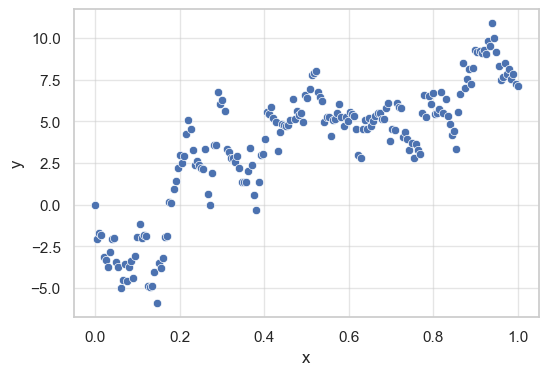

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(sample_data, x="x", y="y",ax=ax);

# 5.2 Piecewise Polynomials and Splines

## Splines

Suppose we have $K$ *knots* $\xi_1<\cdots \xi_K$.
An order-$M$ spline with knots $\xi_j$ is a piecewise polynomial of order $M$ on each interval $(-\infty, \xi_1), (\xi_1, \xi_2), \ldots (\xi_{K-1}, \xi_K), (\xi_K, \infty)$ with continuous derivatives up to order $M-2$ at each knot.

Note that order $M$ means degree $d=M-1$.
In practice we usually use $M=4$ - cubic splines.

## Degrees of freedom

An order-$M$ spline consists of $K+1$ order $M$ polynomials, each contributing $M$ degrees of freedom.
The boundary conditions at the $K$ knots each remove $M-2$ degrees of freedom, so in total we have

\begin{equation}
    \text{df} = M + K
\end{equation}

## Spline bases

There are many equivalent splines bases.
The *$B$-spline* basis is efficient even for large $K$ so is often used.

## B splines

# Examples

Let's try to fit some splines

In [15]:
def make_cubic_spline_model(x, y, n_knots=None, df=None, knots=None, knot_strategy="quantiles", boundary_condition=None):
    """Create a cubic spline model."""
    # Resolve boundary condition
    if boundary_condition is None:
        spline_class = CubicSpline
    elif boundary_condition == "natural":
        spline_class = NaturalCubicSpline
    else:
        raise ValueError("Invalid boundary condition. Use 'natural' or None.")

    # Resolve df and n_knots
    if n_knots is None and df is None:
        raise ValueError("Either n_knots oŸr df must be specified.")
    if n_knots is not None and df is not None:
        raise ValueError("Only one of n_knots or df can be specified.")
    if df is not None:
        if boundary_condition is None:
            n_knots = df - 4
        else:
            n_knots = df - 2
    
    X = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y)

    model = Pipeline([
        ("spline", spline_class(min=x.min(), max=x.max(), n_knots=n_knots, knots=knots, knot_strategy=knot_strategy)),
        ("linear", LinearRegression())
    ])
    model.fit(X, y)
    return model

Start by looking at different degrees of freedom:

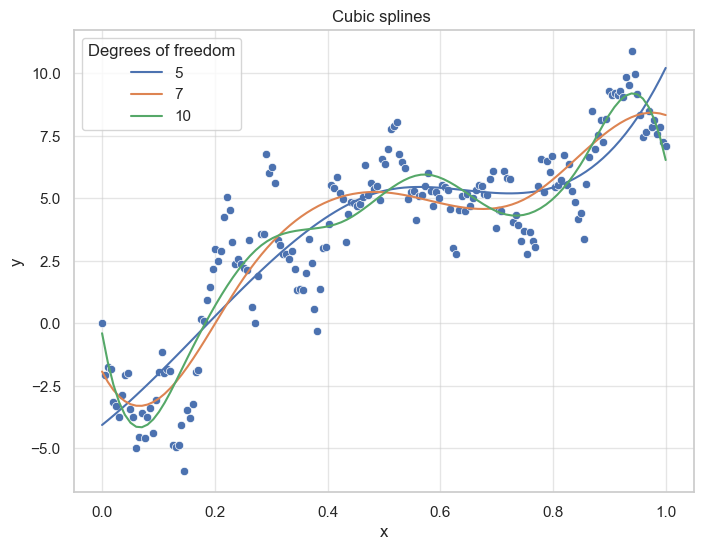

In [16]:
degrees_of_freedom = [5, 7, 10]

fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(sample_data, x="x", y="y", ax=ax)

x_plot = np.linspace(x.min(), x.max(), 100)
for df in degrees_of_freedom:
    model = make_cubic_spline_model(x, y, df=df)
    ax.plot(x_plot, model.predict(x_plot.reshape(-1, 1)), label=str(df))

ax.set_title("Cubic splines ")
ax.legend(title="Degrees of freedom");

Now let's compare cubic splines with natural cubic splines

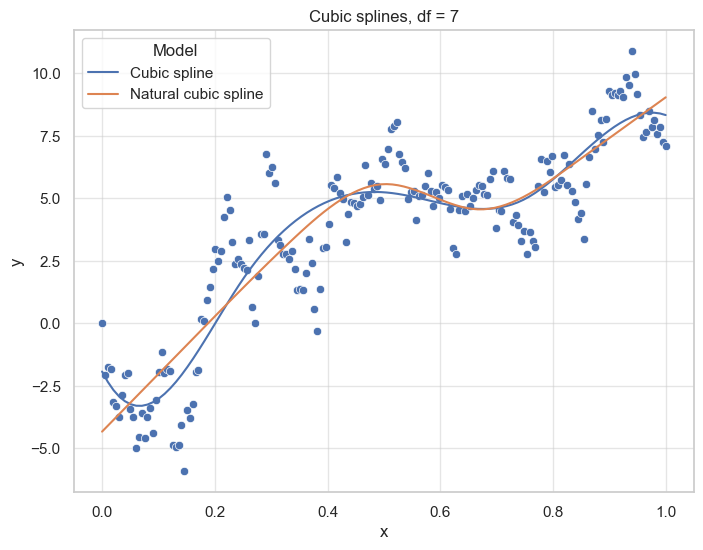

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(sample_data, x="x", y="y", ax=ax)

x_plot = np.linspace(x.min(), x.max(), 100)

cubic_spline_model = make_cubic_spline_model(x, y, df=7, boundary_condition=None)
ax.plot(x_plot, cubic_spline_model.predict(x_plot.reshape(-1, 1)), label="Cubic spline")

natural_cubic_spline_model = make_cubic_spline_model(x, y, df=7, boundary_condition="natural")
ax.plot(x_plot, natural_cubic_spline_model.predict(x_plot.reshape(-1, 1)), label="Natural cubic spline")

ax.set_title("Cubic splines, df = 7")
ax.legend(title="Model");

## Regressio

I want to compare the above with regressio

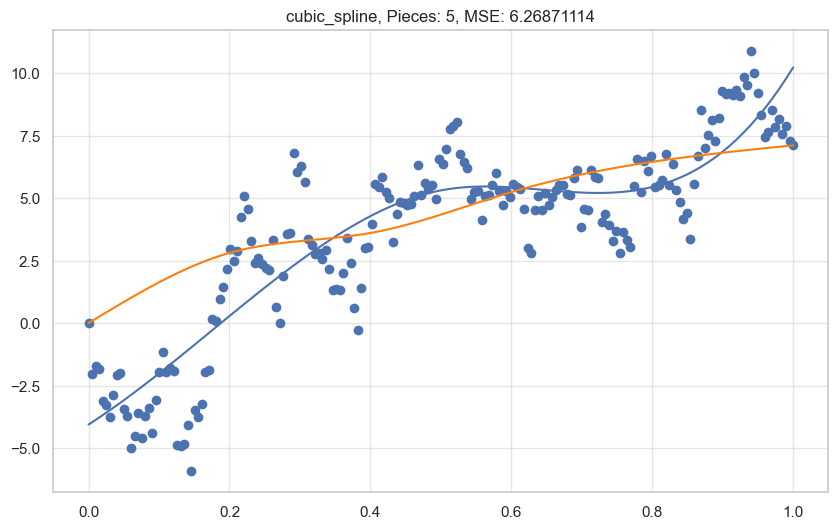

In [33]:
from regressio.models import cubic_spline

regressio_model = cubic_spline(pieces=5)
regressio_model.fit(x, y, plot=False, confidence_interval=0.90)

model = make_cubic_spline_model(x, y, n_knots=1)
ax = plt.gca()
ax.plot(x_plot, model.predict(x_plot.reshape(-1, 1)), label="Basis Exp")

regressio_model.plot_model(x, y)
ax.legend();

I'm worried that these don't agree (seemingly at all)

In [34]:
def fit_and_plot_patsy_cubic_spline(x, y, df=7, degree=3, plot_basis=False, ax=None, **plt_kwargs):
    """
    Fit a cubic spline to data using patsy and plot the results.
    
    Parameters:
    -----------
    x : array-like
        Input feature values
    y : array-like
        Target values
    df : int, default=7
        Degrees of freedom for the spline (controls flexibility)
    degree : int, default=3
        Polynomial degree (3 for cubic splines)
    plot_basis : bool, default=False
        Whether to plot the basis functions in a separate figure
    ax : matplotlib axis, optional
        Axis to plot on, creates new figure if None
    **plt_kwargs : dict
        Additional arguments to pass to the plot function
    
    Returns:
    --------
    tuple: (model, ax)
        The fitted model and the matplotlib axis
    """
    import patsy
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression
    
    # Ensure inputs are numpy arrays
    x = np.asarray(x).flatten()
    y = np.asarray(y).flatten()
    
    # Create spline basis with patsy
    X_spline = patsy.bs(x, df=df, degree=degree, include_intercept=True)
    
    # Fit linear regression on the spline basis
    model = LinearRegression()
    model.fit(X_spline, y)
    
    # Create evaluation points for smooth curve
    x_eval = np.linspace(x.min(), x.max(), 200)
    X_eval = patsy.bs(x_eval, df=df, degree=degree, include_intercept=True)
    y_pred = model.predict(X_eval)
    
    # Plot basis functions if requested
    if plot_basis:
        fig_basis, ax_basis = plt.subplots(figsize=(10, 6))
        for i in range(X_eval.shape[1]):
            ax_basis.plot(x_eval, X_eval[:, i], label=f'Basis {i+1}')
        
        # Calculate interior knots (patsy places knots at quantiles)
        n_interior = df - degree - 1
        knots = np.linspace(0, 1, n_interior+2)[1:-1]
        knots = x.min() + knots * (x.max() - x.min())
        ax_basis.plot(knots, np.zeros_like(knots), 'k|', ms=20, label='Interior Knots')
        
        ax_basis.set_title(f'Cubic B-spline Basis Functions (df={df})')
        ax_basis.set_xlabel('x')
        ax_basis.set_ylabel('Basis Function Value')
        ax_basis.legend(loc='best')
        ax_basis.grid(True)
        plt.tight_layout()
    
    # Plot the fitted spline
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot data points
    ax.scatter(x, y, alpha=0.5, label='Data', color='tab:blue')
    
    # Plot fitted spline
    ax.plot(x_eval, y_pred, label=f'Cubic Spline (df={df})', **plt_kwargs)
    
    # Add knot positions to the plot
    n_interior = df - degree - 1
    knots = np.linspace(0, 1, n_interior+2)[1:-1]
    knots = x.min() + knots * (x.max() - x.min())
    ax.plot(knots, np.zeros_like(knots), 'k|', ms=15)
    
    ax.set_title('Cubic Spline Regression')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(loc='best')
    ax.grid(True)
    
    return model, ax

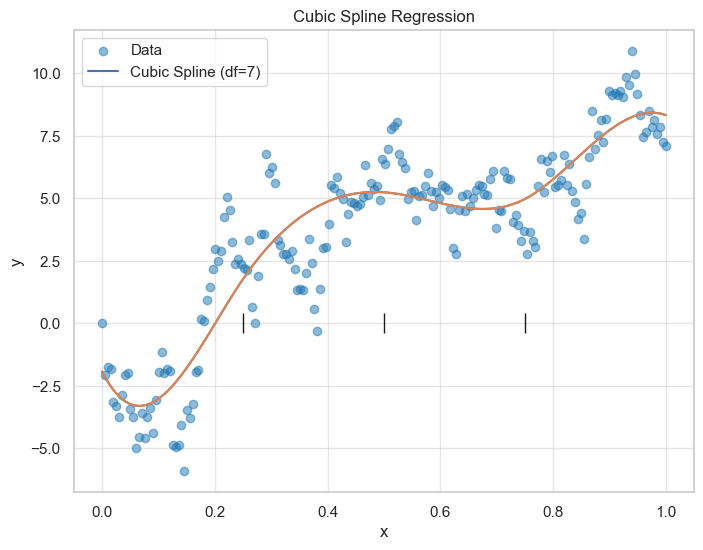

In [38]:
_, ax = fit_and_plot_patsy_cubic_spline(x, y, df=7, degree=3)

model = make_cubic_spline_model(x, y, df=7)
ax.plot(x_plot, model.predict(x_plot.reshape(-1, 1)), label="Basis Exp")

In [74]:
def fit_and_plot_natural_cubic_spline(x, y, df=7, plot_basis=False, ax=None, 
                                      include_plot_data=True, constraints=None, **plt_kwargs):
    """
    Fit a natural cubic spline to data using patsy and plot the results.
    
    Parameters:
    -----------
    x : array-like
        Input feature values
    y : array-like
        Target values
    df : int, default=7
        Degrees of freedom for the spline (controls flexibility)
        Ignored if knots is provided
    knots : array-like, optional
        Explicit knot positions. If provided, overrides df
    plot_basis : bool, default=False
        Whether to plot the basis functions in a separate figure
    ax : matplotlib axis, optional
        Axis to plot on, creates new figure if None
    include_plot_data : bool, default=True
        Whether to plot the data points
    **plt_kwargs : dict
        Additional arguments to pass to the plot function
    
    Returns:
    --------
    tuple: (model, ax)
        The fitted model and the matplotlib axis
    """
    import patsy
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression
    
    # Ensure inputs are numpy arrays
    x = np.asarray(x).flatten()
    y = np.asarray(y).flatten()
    
    # Create natural spline basis with patsy (cr stands for cubic regression spline)
    X_spline = patsy.cr(x, df=df, constraints=constraints)
    # For display, estimate where knots were placed (quantiles by default in patsy)
    n_interior = df - 1  # For natural cubic splines, df = n_interior + 1
    display_knots = np.percentile(x, np.linspace(0, 100, n_interior+2)[1:-1])
    
    # Fit linear regression on the spline basis
    model = LinearRegression(fit_intercept=True)  # Handle intercept in the linear model
    model.fit(X_spline, y)
    
    # Create evaluation points for smooth curve
    x_eval = np.linspace(min(x) - 0.5 * (max(x) - min(x)),  # extend a bit beyond data range
                         max(x) + 0.5 * (max(x) - min(x)), 
                         300)
    X_eval = patsy.cr(x_eval, df=df, constraints=constraints)
    y_pred = model.predict(X_eval)
    
    # Plot basis functions if requested
    if plot_basis:
        fig_basis, ax_basis = plt.subplots(figsize=(10, 6))
        for i in range(X_eval.shape[1]):
            ax_basis.plot(x_eval, X_eval[:, i], label=f'Basis {i+1}')
        
        ax_basis.plot(display_knots, np.zeros_like(display_knots), 
                     'k|', ms=20, label='Interior Knots')
        
        ax_basis.set_title(f'Natural Cubic Spline Basis Functions (df={X_spline.shape[1]})')
        ax_basis.set_xlabel('x')
        ax_basis.set_ylabel('Basis Function Value')
        ax_basis.legend(loc='best')
        ax_basis.grid(True)
        plt.tight_layout()
    
    # Plot the fitted spline
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot data points
    if include_plot_data:
        ax.scatter(x, y, alpha=0.5, label='Data', color='tab:blue')
    
    label = f'Natural Cubic Spline (df={df})'
    ax.plot(x_eval, y_pred, label=label, **plt_kwargs)
    
    # Add knot positions to the plot
    ax.plot(display_knots, np.zeros_like(display_knots), 'k|', ms=15)
    
    ax.set_title('Natural Cubic Spline Regression')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(loc='best')
    ax.grid(True)
    
    return model, ax

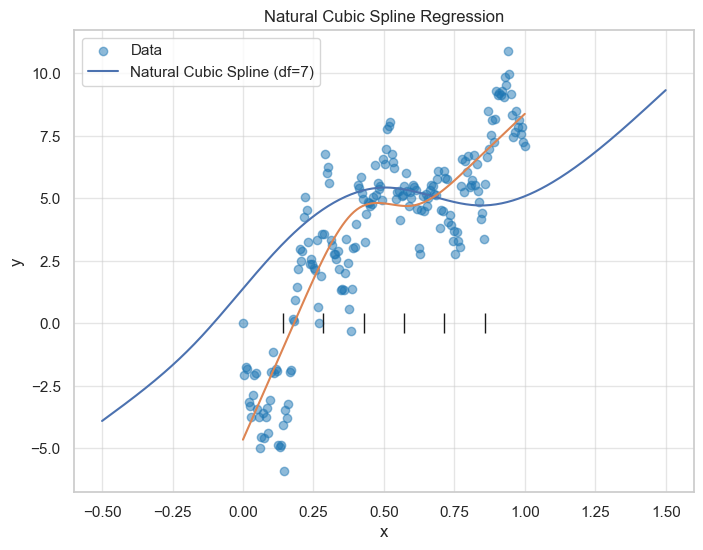

In [75]:
_, ax = fit_and_plot_natural_cubic_spline(x, y, df=7, constraints=None)

model = make_cubic_spline_model(x, y, df=6, boundary_condition="natural")
ax.plot(x_plot, model.predict(x_plot.reshape(-1, 1)))

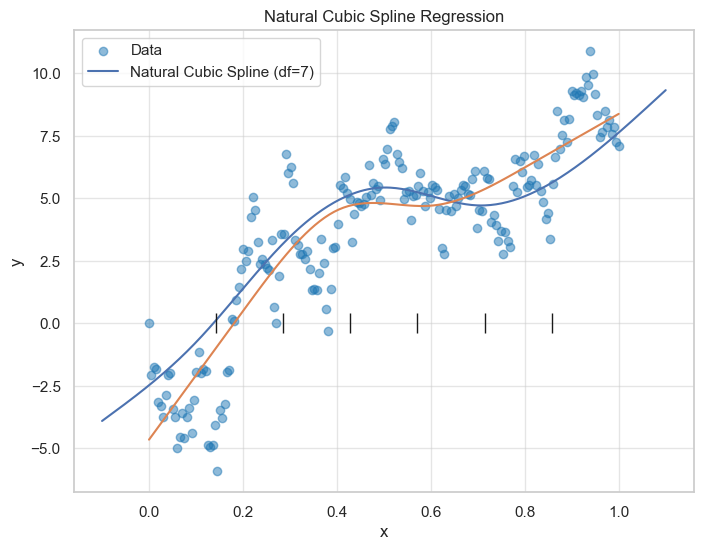

In [73]:
_, ax = fit_and_plot_natural_cubic_spline(x, y, df=7, constraints=None)

model = make_cubic_spline_model(x, y, df=6, boundary_condition="natural")
ax.plot(x_plot, model.predict(x_plot.reshape(-1, 1)))

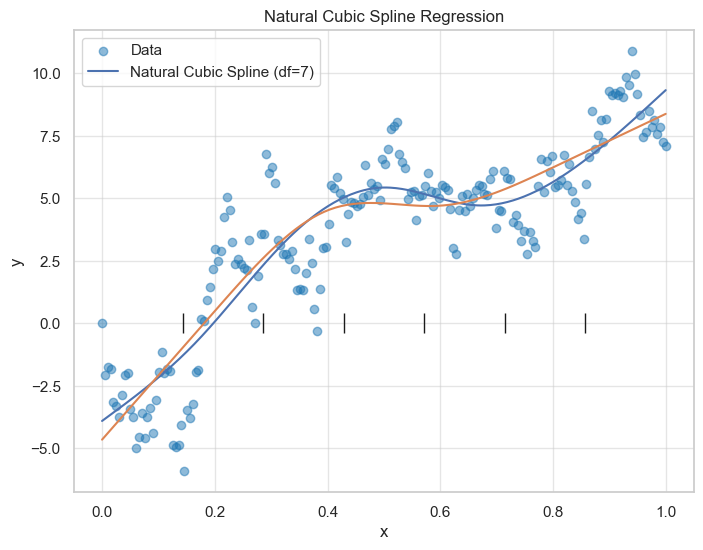

In [70]:
_, ax = fit_and_plot_natural_cubic_spline(x, y, df=7, constraints=None)

model = make_cubic_spline_model(x, y, df=6, boundary_condition="natural")
ax.plot(x_plot, model.predict(x_plot.reshape(-1, 1)), label="Basis Exp")

The fixed version

In [78]:
def fit_and_plot_natural_cubic_spline(x, y, df=7, plot_basis=False, ax=None, 
                                     include_plot_data=True, constraints=None, **plt_kwargs):
    """
    Fit a natural cubic spline to data using patsy and plot the results.
    
    Parameters:
    -----------
    x : array-like
        Input feature values
    y : array-like
        Target values
    df : int, default=7
        Degrees of freedom for the spline (controls flexibility)
    plot_basis : bool, default=False
        Whether to plot the basis functions in a separate figure
    ax : matplotlib axis, optional
        Axis to plot on, creates new figure if None
    include_plot_data : bool, default=True
        Whether to plot the data points
    constraints : array-like, optional
        Constraints to apply to the basis
    **plt_kwargs : dict
        Additional arguments to pass to the plot function
    
    Returns:
    --------
    tuple: (model, ax)
        The fitted model and the matplotlib axis
    """
    import patsy
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression
    
    # Ensure inputs are numpy arrays
    x = np.asarray(x).flatten()
    y = np.asarray(y).flatten()
    
    # Data range for knots
    x_min, x_max = x.min(), x.max()
    
    # Create a formula string for the natural cubic spline
    # This allows us to preserve the design info
    formula = "cr(x, df={})".format(df)
    
    # Create design matrix with design info preserved
    X_spline = patsy.dmatrix(formula, {"x": x}, return_type='dataframe')
    
    # Store the design info for consistent prediction
    design_info = X_spline.design_info
    
    # For display, estimate where knots were placed (quantiles by default in patsy)
    n_interior = df - 1  # For natural cubic splines, df = n_interior + 1
    display_knots = np.percentile(x, np.linspace(0, 100, n_interior+2)[1:-1])
    
    # Fit linear regression on the spline basis (no intercept since patsy includes it)
    model = LinearRegression(fit_intercept=False)
    model.fit(X_spline, y)
    
    # Create evaluation points for smooth curve
    x_eval = np.linspace(min(x) - 0.5 * (max(x) - min(x)),
                        max(x) + 0.5 * (max(x) - min(x)), 
                        300)
    
    # Generate basis for evaluation points using the formula
    X_eval = patsy.build_design_matrix([{"x": x_eval}], design_info)
    y_pred = model.predict(X_eval)
    
    # Plot basis functions if requested
    if plot_basis:
        fig_basis, ax_basis = plt.subplots(figsize=(10, 6))
        for i in range(X_eval.shape[1]):
            ax_basis.plot(x_eval, X_eval[:, i], label=f'Basis {i+1}')
        
        ax_basis.plot(display_knots, np.zeros_like(display_knots), 
                     'k|', ms=20, label='Interior Knots')
        
        ax_basis.set_title(f'Natural Cubic Spline Basis Functions (df={df})')
        ax_basis.set_xlabel('x')
        ax_basis.set_ylabel('Basis Function Value')
        ax_basis.legend(loc='best')
        ax_basis.grid(True)
        plt.tight_layout()
    
    # Plot the fitted spline
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot data points
    if include_plot_data:
        ax.scatter(x, y, alpha=0.5, label='Data', color='tab:blue')
    
    label = f'Natural Cubic Spline (df={df})'
    ax.plot(x_eval, y_pred, label=label, **plt_kwargs)
    
    # Add knot positions to the plot
    ax.plot(display_knots, np.zeros_like(display_knots), 'k|', ms=15)
    
    ax.set_title('Natural Cubic Spline Regression')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(loc='best')
    ax.grid(True)
    
    return model, ax

In [93]:
def fit_and_plot_natural_cubic_spline(x, y, df=7, plot_basis=False, ax=None, 
                                     include_plot_data=True, constraints=None, **plt_kwargs):
    """
    Fit a natural cubic spline to data using patsy and plot the results.
    
    Parameters:
    -----------
    x : array-like
        Input feature values
    y : array-like
        Target values
    df : int, default=7
        Degrees of freedom for the spline (controls flexibility)
    plot_basis : bool, default=False
        Whether to plot the basis functions in a separate figure
    ax : matplotlib axis, optional
        Axis to plot on, creates new figure if None
    include_plot_data : bool, default=True
        Whether to plot the data points
    constraints : array-like, optional
        Constraints to apply to the basis
    **plt_kwargs : dict
        Additional arguments to pass to the plot function
    
    Returns:
    --------
    tuple: (model, ax)
        The fitted model and the matplotlib axis
    """
    import patsy
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression
    
    # Ensure inputs are numpy arrays
    x = np.asarray(x).flatten()
    y = np.asarray(y).flatten()
    
    # Data range for knots
    x_min, x_max = x.min(), x.max()
    
    # Instead of creating a separate basis for prediction later,
    # we'll include both the training x and evaluation points in a single design matrix
    # This ensures consistent basis functions
    
    # Create evaluation points for smooth curve
    x_eval = np.linspace(min(x) - 0.3 * (max(x) - min(x)),
                        max(x) + 0.3 * (max(x) - min(x)), 
                        300)
    
    # Combine original x and evaluation x
    x_combined = np.concatenate([x, x_eval])
    
    # Create the full design matrix using patsy
    formula = "cr(x, df={})".format(df)
    X_combined = patsy.dmatrix(formula, {"x": x_combined})
    
    # Split back into training and evaluation matrices
    X_spline = X_combined[:len(x)]
    X_eval = X_combined[len(x):]
    
    # For display, estimate where knots were placed (quantiles by default in patsy)
    n_interior = df - 1  # For natural cubic splines, df = n_interior + 1
    display_knots = np.percentile(x, np.linspace(0, 100, n_interior+2)[1:-1])
    
    # Fit linear regression on the spline basis (no intercept since patsy includes it)
    model = LinearRegression(fit_intercept=False)
    model.fit(X_spline, y)
    
    # Get predictions for the evaluation points
    y_pred = model.predict(X_eval)
    
    # Plot basis functions if requested
    if plot_basis:
        fig_basis, ax_basis = plt.subplots(figsize=(10, 6))
        for i in range(X_eval.shape[1]):
            ax_basis.plot(x_eval, X_eval[:, i], label=f'Basis {i+1}')
        
        ax_basis.plot(display_knots, np.zeros_like(display_knots), 
                     'k|', ms=20, label='Interior Knots')
        
        ax_basis.set_title(f'Natural Cubic Spline Basis Functions (df={df})')
        ax_basis.set_xlabel('x')
        ax_basis.set_ylabel('Basis Function Value')
        ax_basis.legend(loc='best')
        ax_basis.grid(True)
        plt.tight_layout()
    
    # Plot the fitted spline
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot data points
    if include_plot_data:
        ax.scatter(x, y, alpha=0.5, label='Data', color='tab:blue')
    
    label = f'Natural Cubic Spline (df={df})'
    ax.plot(x_eval, y_pred, label=label, **plt_kwargs)
    
    # Add knot positions to the plot
    ax.plot(display_knots, np.zeros_like(display_knots), 'k|', ms=15)
    
    ax.set_title('Natural Cubic Spline Regression')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(loc='best')
    ax.grid(True)
    
    return model, ax

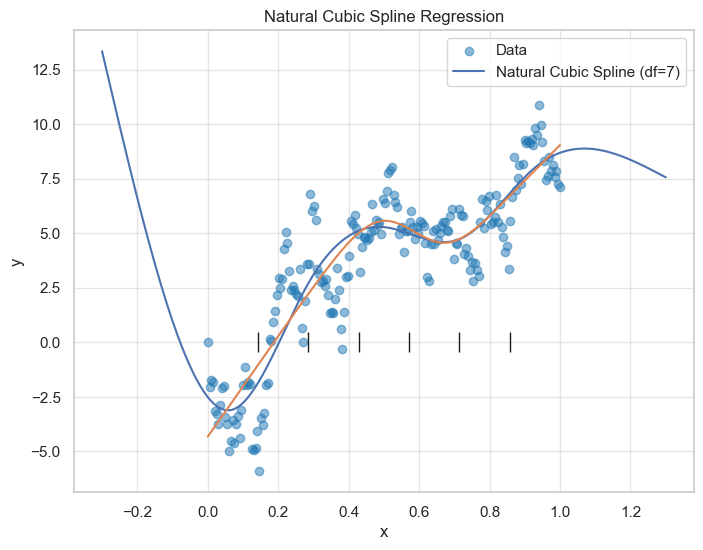

In [94]:
_, ax = fit_and_plot_natural_cubic_spline(x, y, df=7, constraints=None)

model = make_cubic_spline_model(x, y, df=7, boundary_condition="natural")
ax.plot(x_plot, model.predict(x_plot.reshape(-1, 1)), label="Basis Exp")

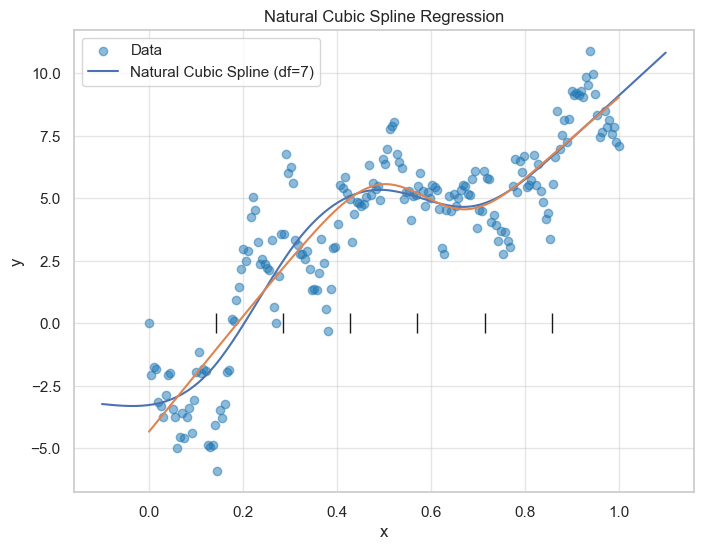

In [91]:
_, ax = fit_and_plot_natural_cubic_spline(x, y, df=7, constraints=None)

model = make_cubic_spline_model(x, y, df=7, boundary_condition="natural")
ax.plot(x_plot, model.predict(x_plot.reshape(-1, 1)), label="Basis Exp")


Scipy BSpline

In [39]:
def fit_and_plot_scipy_bspline(x, y, n_interior_knots=3, degree=3, plot_basis=False, ax=None, knot_strategy="uniform", **plt_kwargs):
    """
    Fit a cubic spline to data using scipy.interpolate.BSpline and plot the results.
    
    Parameters:
    -----------
    x : array-like
        Input feature values
    y : array-like
        Target values
    n_interior_knots : int, default=3
        Number of interior knots (controls flexibility)
    degree : int, default=3
        Polynomial degree (3 for cubic splines)
    plot_basis : bool, default=False
        Whether to plot the basis functions in a separate figure
    ax : matplotlib axis, optional
        Axis to plot on, creates new figure if None
    knot_strategy : str, default="uniform"
        Strategy for placing knots: "uniform" or "quantiles"
    **plt_kwargs : dict
        Additional arguments to pass to the plot function
    
    Returns:
    --------
    tuple: (coef, knots, ax)
        The fitted coefficients, knot sequence, and matplotlib axis
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.interpolate import BSpline
    from sklearn.linear_model import LinearRegression
    
    # Ensure inputs are numpy arrays
    x = np.asarray(x).flatten()
    y = np.asarray(y).flatten()
    
    # Scale x to [0, 1] for numerical stability
    x_min, x_max = x.min(), x.max()
    x_scaled = (x - x_min) / (x_max - x_min)
    
    # Create interior knots
    if knot_strategy == "uniform":
        interior_knots = np.linspace(0, 1, n_interior_knots + 2)[1:-1]
    elif knot_strategy == "quantiles":
        interior_knots = np.percentile(x_scaled, 
                                       np.linspace(0, 100, n_interior_knots + 2)[1:-1])
    else:
        raise ValueError("knot_strategy must be 'uniform' or 'quantiles'")
    
    # Create complete knot sequence with repeated boundary knots
    knots = np.concatenate([
        [0] * (degree + 1),  # left boundary knots
        interior_knots,
        [1] * (degree + 1)   # right boundary knots
    ])
    
    # Number of basis functions
    n_basis = len(interior_knots) + degree + 1
    
    # Create basis matrix for training data
    X_spline = np.zeros((len(x_scaled), n_basis))
    for i in range(n_basis):
        coef = np.zeros(n_basis)
        coef[i] = 1
        bspline = BSpline(knots, coef, degree)
        X_spline[:, i] = bspline(x_scaled)
    
    # Fit regression model
    model = LinearRegression(fit_intercept=False)
    model.fit(X_spline, y)
    coef = model.coef_
    
    # Create evaluation points for smooth curve
    x_eval_scaled = np.linspace(0, 1, 200)
    x_eval = x_min + x_eval_scaled * (x_max - x_min)
    
    # Create basis matrix for evaluation points
    X_eval = np.zeros((len(x_eval_scaled), n_basis))
    for i in range(n_basis):
        coef_basis = np.zeros(n_basis)
        coef_basis[i] = 1
        bspline = BSpline(knots, coef_basis, degree)
        X_eval[:, i] = bspline(x_eval_scaled)
    
    # Calculate predictions
    y_pred = X_eval @ coef
    
    # Plot basis functions if requested
    if plot_basis:
        fig_basis, ax_basis = plt.subplots(figsize=(10, 6))
        for i in range(n_basis):
            ax_basis.plot(x_eval, X_eval[:, i], label=f'Basis {i+1}')
        
        # Convert interior knots back to original scale
        interior_knots_orig = x_min + interior_knots * (x_max - x_min)
        ax_basis.plot(interior_knots_orig, np.zeros_like(interior_knots_orig), 
                     'k|', ms=20, label='Interior Knots')
        
        ax_basis.set_title(f'Cubic B-spline Basis Functions (n_interior_knots={n_interior_knots})')
        ax_basis.set_xlabel('x')
        ax_basis.set_ylabel('Basis Function Value')
        ax_basis.legend(loc='best')
        ax_basis.grid(True)
        plt.tight_layout()
    
    # Plot the fitted spline
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot data points
    ax.scatter(x, y, alpha=0.5, label='Data', color='tab:blue')
    
    # Plot fitted spline
    ax.plot(x_eval, y_pred, label=f'B-Spline (knots={n_interior_knots})', **plt_kwargs)
    
    # Add knot positions to the plot
    interior_knots_orig = x_min + interior_knots * (x_max - x_min)
    ax.plot(interior_knots_orig, np.zeros_like(interior_knots_orig), 'k|', ms=15)
    
    ax.set_title('Cubic B-Spline Regression')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(loc='best')
    ax.grid(True)
    
    return coef, knots, ax

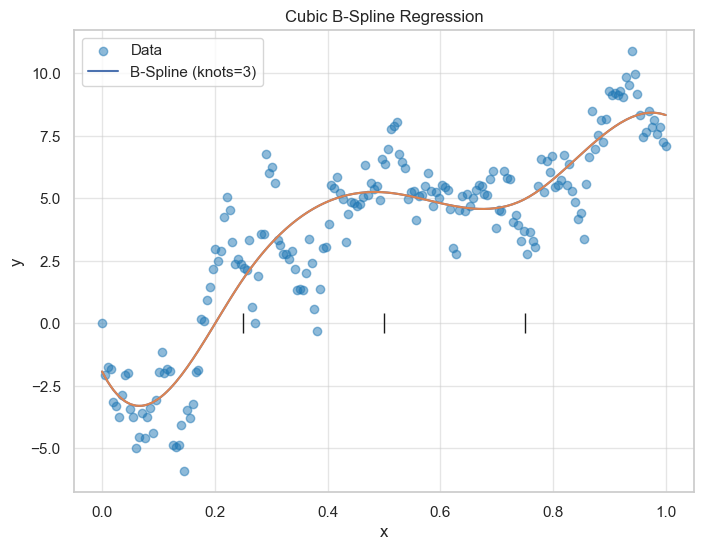

In [42]:
_, _, ax = fit_and_plot_scipy_bspline(x, y, n_interior_knots=3, degree=3)

model = make_cubic_spline_model(x, y, df=7)
ax.plot(x_plot, model.predict(x_plot.reshape(-1, 1)), label="Basis Exp")

# Other spline implementations

In [ ]:
regressio_model

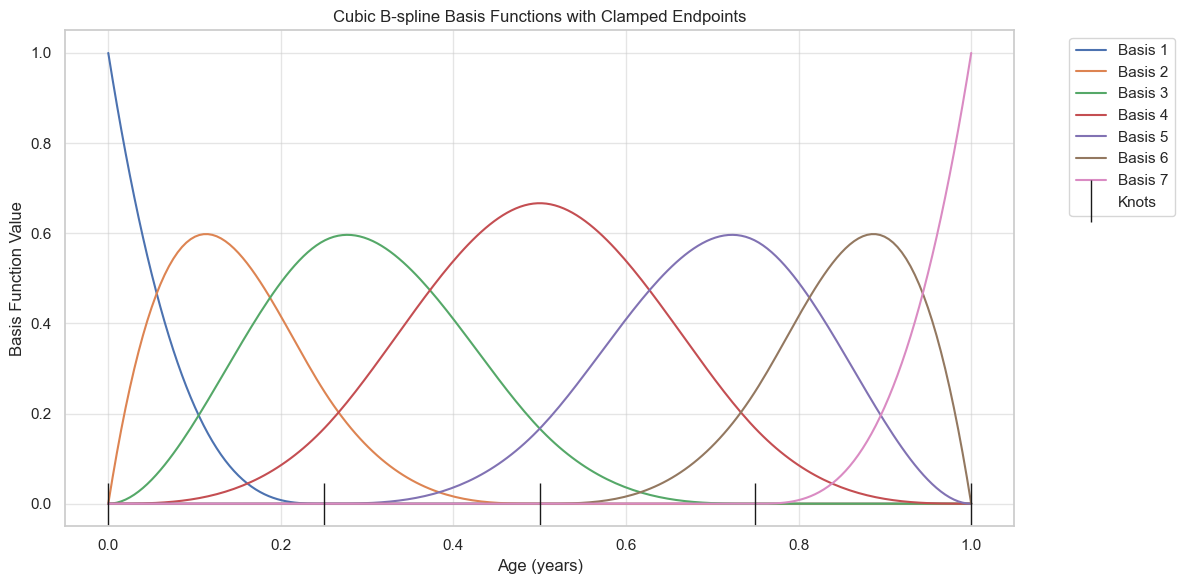

In [ ]:
from scipy.interpolate import BSpline
import numpy as np

# # Get age data and sort it
# age = bone_data['age'].values
# age_sorted = np.sort(age)

# Create interior knots at quantiles
n_interior = 3
interior_knots = np.linspace(0, 1, n_interior+2)[1: -1]

# Create complete knot sequence with repeated boundary knots
degree = 3
knots = np.concatenate([
    [0] * (degree + 1),  # left boundary knots
    interior_knots,
    [1] * (degree + 1)   # right boundary knots
])

# Create the B-spline basis
n_basis = len(interior_knots) + degree + 1

# Create a fine grid for evaluation
x_eval = np.linspace(0, 1, 200)

# Calculate B-spline basis functions
bsplines = []
for i in range(n_basis):
    coef = np.zeros(n_basis)
    coef[i] = 1
    bspline = BSpline(knots, coef, degree)
    bsplines.append(bspline(x_eval))

# Plot the basis functions
plt.figure(figsize=(12, 6))
for i, basis in enumerate(bsplines):
    plt.plot(x_eval, basis, label=f'Basis {i+1}')

# Plot unique knot locations
unique_knots = np.unique(knots)
plt.plot(unique_knots, np.zeros_like(unique_knots), 'k|', ms=30, label='Knots')

plt.title('Cubic B-spline Basis Functions with Clamped Endpoints')
plt.xlabel('Age (years)')
plt.ylabel('Basis Function Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

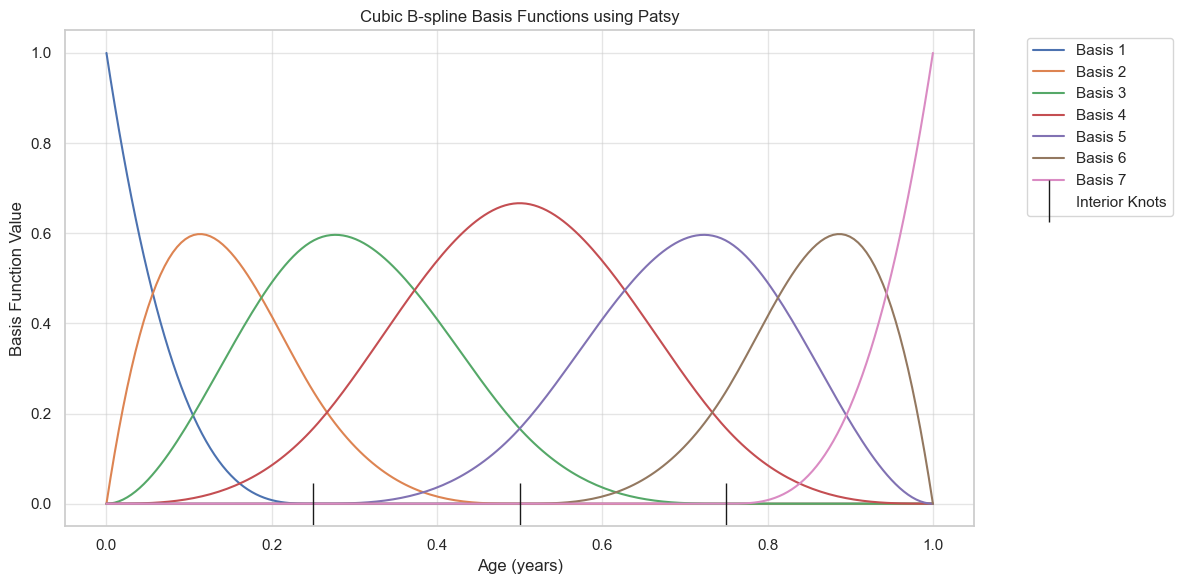

In [10]:
import patsy
import numpy as np
import matplotlib.pyplot as plt

# Create evaluation points
x_eval = np.linspace(0, 1, 200)

# Create B-spline basis with 3 interior knots (bs stands for B-spline)
# degree=3 for cubic splines, df=7 gives us 3 interior knots (df = n_interior_knots + degree + 1)
basis = patsy.bs(x_eval, df=7, degree=3, include_intercept=True)

# Plot the basis functions
plt.figure(figsize=(12, 6))
for i in range(basis.shape[1]):
    plt.plot(x_eval, basis[:, i], label=f'Basis {i+1}')

# Calculate and plot knot positions
# Patsy automatically places knots at quantiles
knots = np.linspace(0, 1, 5)[1:-1]  # 3 interior knots
plt.plot(knots, np.zeros_like(knots), 'k|', ms=30, label='Interior Knots')

plt.title('Cubic B-spline Basis Functions using Patsy')
plt.xlabel('Age (years)')
plt.ylabel('Basis Function Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Patsy

In [97]:
import patsy

In [100]:
sample_data.head()

,x,y
0,0.000000,0.000000
1,0.005025,-2.057126
2,0.010050,-1.721653
3,0.015075,-1.831975
4,0.020101,-3.128145


In [99]:
patsy.dmatrices("y ~ x", sample_data.head())

(DesignMatrix with shape (5, 1)
          y
    0.00000
   -2.05713
   -1.72165
   -1.83197
   -3.12814
   Terms:
     'y' (column 0),
 DesignMatrix with shape (5, 2)
   Intercept        x
           1  0.00000
           1  0.00503
           1  0.01005
           1  0.01508
           1  0.02010
   Terms:
     'Intercept' (column 0)
     'x' (column 1))

In [101]:
outcome, predictors = patsy.dmatrices("y ~ x", sample_data)


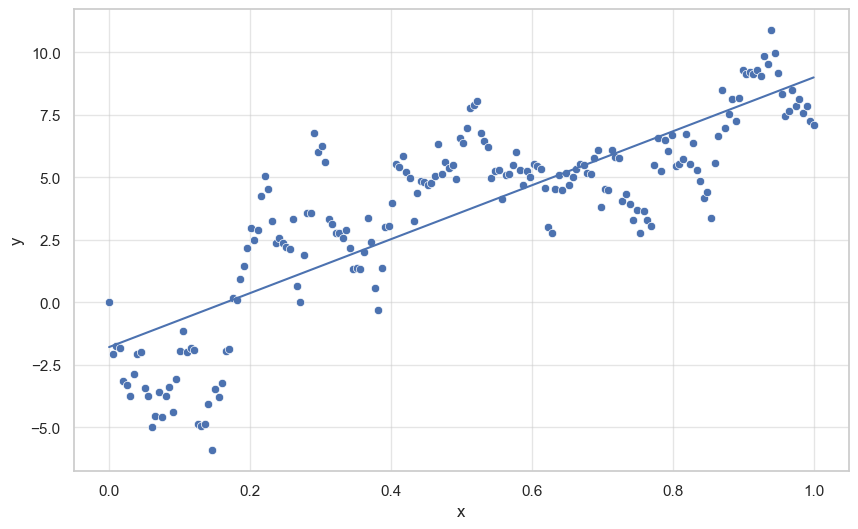

In [108]:
lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(predictors, outcome)
y_pred = lin_reg.predict(predictors)
sns.scatterplot(sample_data, x="x", y="y")
plt.plot(sample_data.x, y_pred)

In [ ]:
patsy.dmatrix("x")

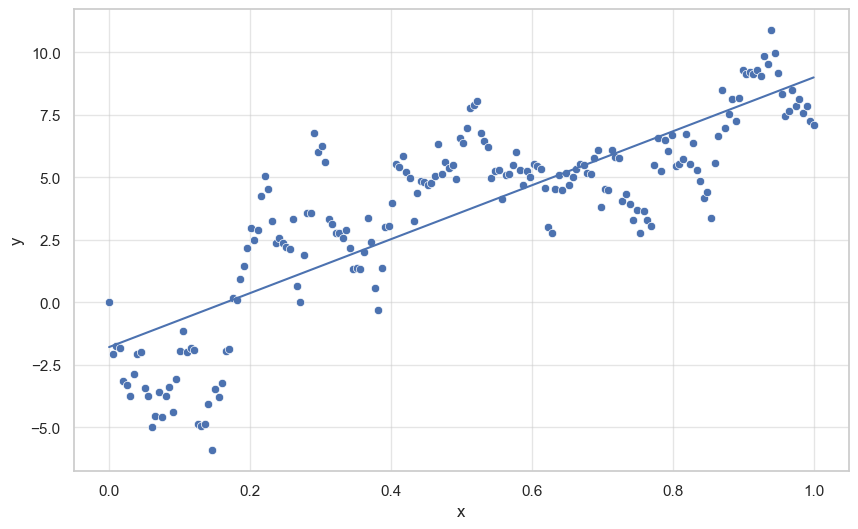

In [117]:
X = patsy.dmatrix("x", sample_data.x)

lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X, y)
y_pred = lin_reg.predict(X)
sns.scatterplot(sample_data, x="x", y="y")
plt.plot(sample_data.x, y_pred)

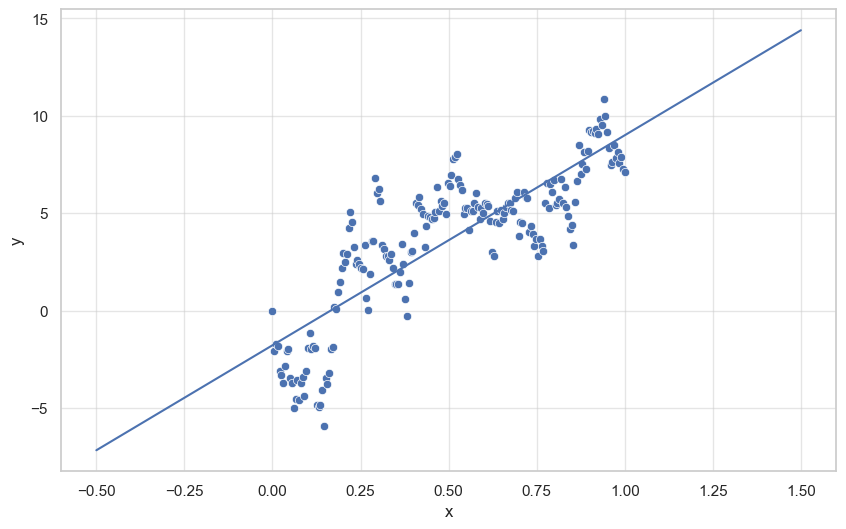

In [118]:
x_new = np.linspace(-0.5, 1.5, 100)
X_new = patsy.build_design_matrices([X.design_info], {"x": x_new})[0]

y_pred = lin_reg.predict(X_new)
sns.scatterplot(sample_data, x="x", y="y")
plt.plot(x_new, y_pred)

Now let's try this with splines

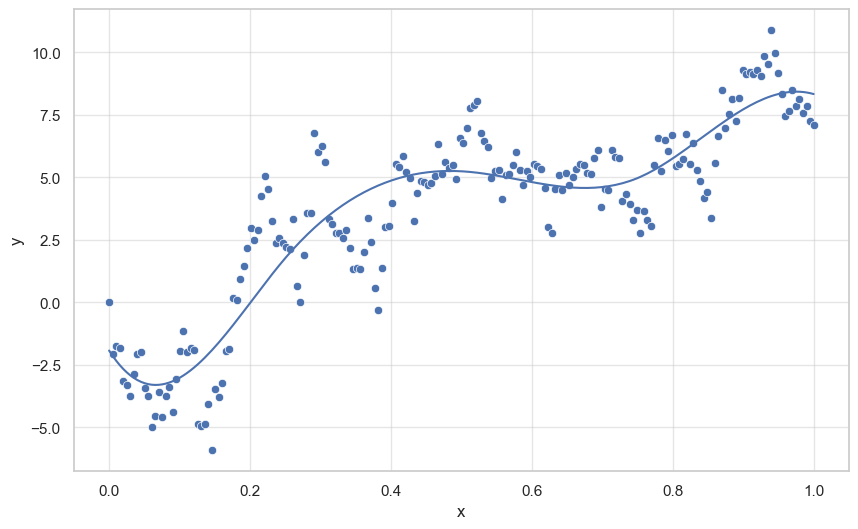

In [ ]:
X = patsy.dmatrix("bs(x, df=7, degree=3, include_intercept=True)", {"x": x})

lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X, y)
y_pred = lin_reg.predict(X)
sns.scatterplot(sample_data, x="x", y="y")
plt.plot(sample_data.x, y_pred)

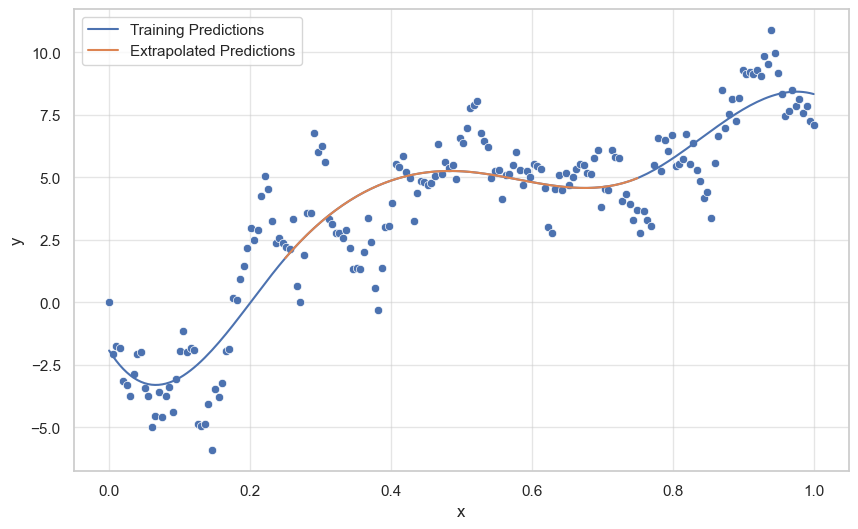

In [123]:
X = patsy.dmatrix("bs(x, df=7, degree=3, include_intercept=True)", {"x": x})

lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X, y)
y_pred = lin_reg.predict(X)

x_new = np.linspace(0.25, 0.75, 100)
X_new = patsy.build_design_matrices([X.design_info], {"x": x_new})[0]
y_new_pred = lin_reg.predict(X_new)

sns.scatterplot(sample_data, x="x", y="y")
plt.plot(sample_data.x, y_pred, label="Training Predictions")
plt.plot(x_new, y_new_pred, label="Extrapolated Predictions")
plt.legend();

Now let's try it with natural splines

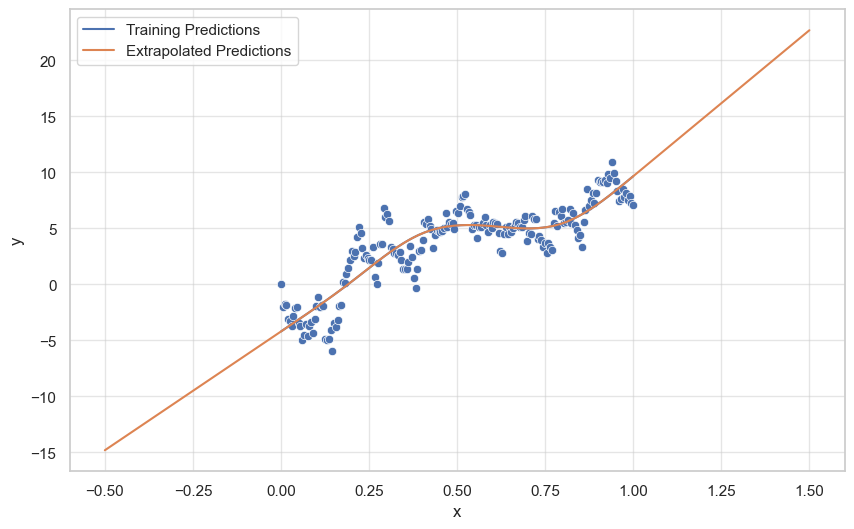

In [144]:
X = patsy.dmatrix("cr(x, df=6)", {"x": x})

lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X, y)
y_pred = lin_reg.predict(X)

x_new = np.linspace(-0.5, 1.5, 100)
X_new = patsy.build_design_matrices([X.design_info], {"x": x_new})[0]
y_new_pred = lin_reg.predict(X_new)

sns.scatterplot(sample_data, x="x", y="y")
plt.plot(sample_data.x, y_pred, label="Training Predictions")
plt.plot(x_new, y_new_pred, label="Extrapolated Predictions")
plt.legend();

In [149]:
def fit_and_plot_natural_cubic_spline(x, y, df=7, plot_basis=False, ax=None, 
                                     include_plot_data=True, constraints=None, **plt_kwargs):
    import patsy
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression
    
    # Ensure inputs are numpy arrays
    x = np.asarray(x).flatten()
    y = np.asarray(y).flatten()

    # First, fit the model on the training data
    X = patsy.dmatrix(f"cr(x, df={df})", {"x": x})
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)
    
    # Create evaluation points
    x_eval = np.linspace(-0.1, 1.1, 200)
    X_eval = patsy.build_design_matrices([X.design_info], {"x": x_eval})[0]
    y_pred = model.predict(X_eval)
    
    # Plot the fitted spline
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot data points
    if include_plot_data:
        ax.scatter(x, y, alpha=0.5, label='Data', color='tab:blue')
    
    label = f'Natural Cubic Spline (df={df})'
    ax.plot(x_eval, y_pred, label=label, **plt_kwargs)
    
    ax.set_title('Natural Cubic Spline Regression')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(loc='best')
    ax.grid(True)
    
    return model, ax

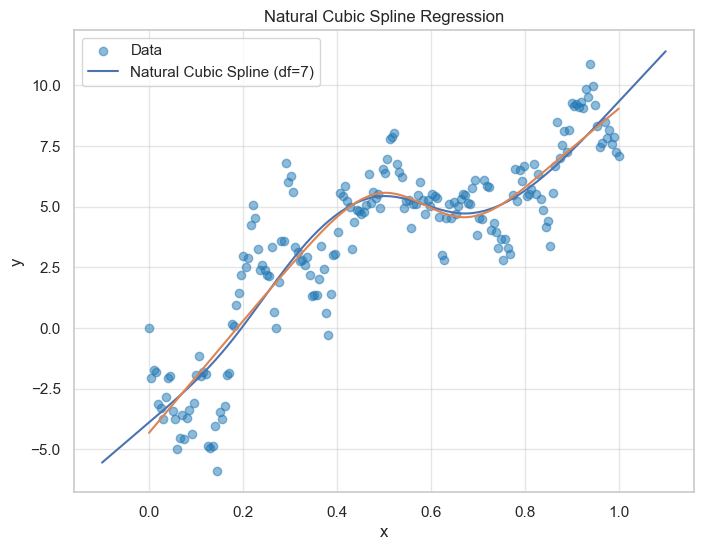

In [150]:
_, ax = fit_and_plot_natural_cubic_spline(x, y, df=7)

model = make_cubic_spline_model(x, y, df=7, boundary_condition="natural")
ax.plot(x_plot, model.predict(x_plot.reshape(-1, 1)), label="Basis Exp")

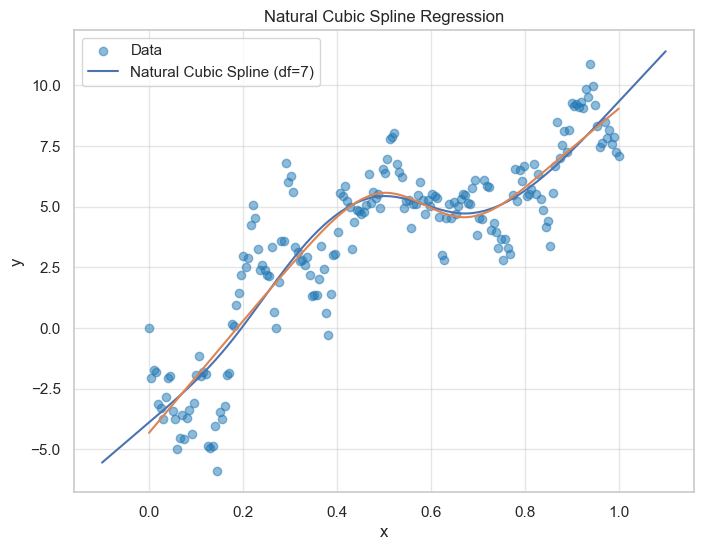

In [139]:
_, ax = fit_and_plot_natural_cubic_spline(x, y, df=7)

model = make_cubic_spline_model(x, y, df=7, boundary_condition="natural")
ax.plot(x_plot, model.predict(x_plot.reshape(-1, 1)), label="Basis Exp")


These aren't exactly the same but they're very close

Finally I want to try the same for SKlearn

In [151]:
from sklearn.preprocessing import SplineTransformer

In [ ]:
def make_sklearn_cubic_spline_model(x, y, df, extrapolation):
Pipeline([
    ("spline", SplineTransformer(n_knots=3, degree=3, include_bias=False)),
    ("linear", LinearRegression())
])